PEHA Script for Hemauer, Saunders, and Desmarais

Last updated: 06/03/2025

In [1]:
### Preprocessing

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
import warnings

warnings.filterwarnings('ignore')

random.seed(1337)

# Data
boehmke_2017_full = pd.read_stata(r"data/boehmke2017.dta")

covariates = ["srcs_decay","nbrs_lag","rpcpinc","totpop","legp_squire",
                "citi6010","unif_rep","unif_dem","time","time_sq","time_cube"]
boehmke_2017 = boehmke_2017_full[["state", "year", "statepol", "adopt"] + covariates].dropna()

# Define X and y
X = boehmke_2017.drop(columns = ['adopt', 'year', 'statepol']).copy()
X = pd.get_dummies(X, columns = ['state'], drop_first = True)  # drop_first avoids perfect multicollinearity
y = boehmke_2017['adopt']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1337, stratify = y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

F1 Macro Score: 0.5111901559535597
Balanced Accuracy Score: 0.5120322737510238
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      8448
         1.0       0.65      0.02      0.05       444

    accuracy                           0.95      8892
   macro avg       0.80      0.51      0.51      8892
weighted avg       0.94      0.95      0.93      8892

Average Precision (AUC PR): 0.1633


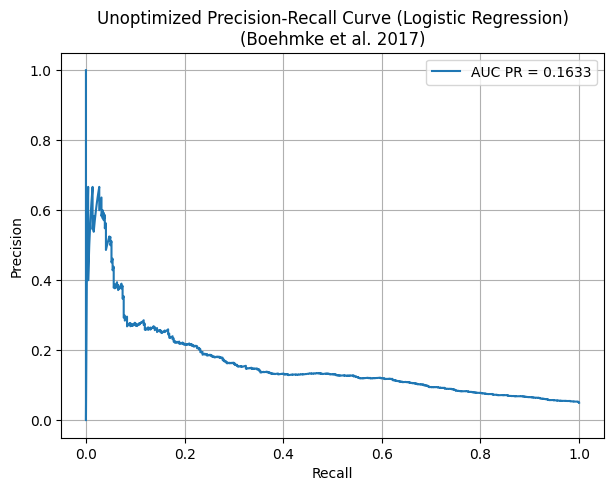

In [ ]:
### Boehmke et al. 2017 PEHA (No Optimization)

# Fit
logistic = linear_model.LogisticRegression(max_iter = 2500, random_state = 1337)

start_time = time.time()
logistic.fit(X_train_scaled, y_train)
end_time = time.time()

# Predict
y_pred = logistic.predict(X_test_scaled)

# Evaluation
print("F1 Macro Score:", f1_score(y_test, y_pred, average = "macro"))
print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get predicted probabilities for the positive class
y_scores = logistic.predict_proba(X_test_scaled)[:, 1]

# Compute average precision (AUC PR)
ap_score = average_precision_score(y_test, y_scores)
print(f"Average Precision (AUC PR): {ap_score:.4f}")

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the PR curve
plt.figure(figsize = (7, 5))
plt.plot(recall, precision, label = f'AUC PR = {ap_score:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Unoptimized Precision-Recall Curve (Logistic)\n(Boehmke et al. 2017)')
plt.legend()
plt.grid(True)
plt.savefig('figures/boehmke2017/unoptimized_logistic_boehmke.png', dpi = 300, bbox_inches = 'tight')
plt.show()

GridSearchCV took 1688.65 seconds
Best parameters found: {'C': 0.001, 'class_weight': {0: 1, 1: 10}, 'fit_intercept': True, 'penalty': None, 'solver': 'lbfgs'}
F1 Macro Score: 0.568815588206347
Balanced Accuracy Score: 0.6140442644348895
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.90      0.93      8448
         1.0       0.15      0.32      0.21       444

    accuracy                           0.87      8892
   macro avg       0.56      0.61      0.57      8892
weighted avg       0.92      0.87      0.90      8892

Average Precision (AUC PR): 0.1638


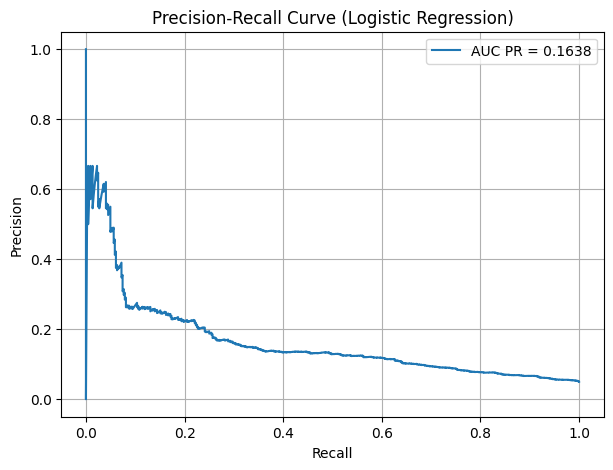

In [ ]:
### Boehmke et al. 2017 PEHA (Optimized)

# Define parameter grid for Logistic Regression
# Base params common to all
common_params = {
    'C': [0.001, 0.01, 0.1, 1, 2],
    'class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}, {0: 1, 1: 6}, {0: 1, 1: 7}, {0: 1, 1: 8}, {0: 1, 1: 9}, {0: 1, 1: 10}],
    'fit_intercept': [True, False]
}

# Build full param grid
param_grid = [
    # lbfgs supports only l2 or none
    {
        **common_params,
        'solver': ['lbfgs'],
        'penalty': ['l2', None]
    },
    # newton-cholesky supports only l2 or none
    {
        **common_params,
        'solver': ['newton-cholesky'],
        'penalty': ['l2', None]
    },
    # liblinear supports l1 and l2 only (no elasticnet or none)
    {
        **common_params,
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2']
    },
    # saga supports l1, l2, elasticnet
    {
        **common_params,
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'l1_ratio': [0, 0.25, 0.5, 0.75, 1]  # Only used if penalty = 'elasticnet', ignored otherwise
    }
]

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator = linear_model.LogisticRegression(max_iter = 2500, random_state = 1337),
    param_grid = param_grid,
    scoring = "f1", # F1 score good for maximizing precision and recall, but average_precision is better for balanced accuracy
    cv = 10,
    n_jobs = -1,
    verbose = 0,
    refit = True 
)

# Fit grid search
start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
end_time = time.time()

print(f"GridSearchCV took {end_time - start_time:.2f} seconds")
print("Best parameters found:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Predict with best estimator
y_pred = best_model.predict(X_test_scaled)

# Evaluation
print("F1 Macro Score:", f1_score(y_test, y_pred, average = "macro"))
print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get predicted probabilities for the positive class
y_scores = best_model.predict_proba(X_test_scaled)[:, 1]

# Compute average precision (AUC PR)
ap_score = average_precision_score(y_test, y_scores)
print(f"Average Precision (AUC PR): {ap_score:.4f}")

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the PR curve
plt.figure(figsize = (7, 5))
plt.plot(recall, precision, label = f'AUC PR = {ap_score:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Optimized Precision-Recall Curve (Logistic)\n(Boehmke et al. 2017)')
plt.legend()
plt.grid(True)
plt.savefig('figures/boehmke2017/optimized_logistic_boehmke.png', dpi = 300, bbox_inches = 'tight')
plt.show()